In [11]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import requests
from pyproj import CRS, Transformer
# !{sys.executable} -m pip install walkscore-api
from walkscore import WalkScoreAPI
import dataframe_image as dfi

In [12]:
# Replace with your own file path to csv of DOT parcels
FilePath = '/Users/hoperuse/summer2021internship/State Surplus/DOTtransitScores.csv'
dot = pd.read_csv(FilePath)

# Removing the word "District" from the column holding the name of thecorresponding districts for each parcel
# to prep for geomerge with State House district lines shapefile.
dot['District'] = dot['District'].str.replace(' District','')

In [13]:
# Creating a summary dataframe with overview data on DOT parcels, to be exported as .png file
summary = pd.DataFrame(columns = ['Categorization','Total Number of Parcels', 'Total Value'])
summary.at[0,'Categorization'] = 'All Parcels'
summary.at[0, 'Total Number of Parcels'] = len(dot.index)
summary.at[0, 'Total Value'] = dot['total_value'].sum()

summary.at[1,'Categorization'] = 'Transit-Friendly'
summary.at[1, 'Total Number of Parcels'] = len(dot[dot['numTransitStops'].notna()])
summary.at[1, 'Total Value'] = dot[dot['numTransitStops'].notna()]['total_value'].sum()

dfi.export(summary,'summary.png')

summary

,Categorization,Total Number of Parcels,Total Value
0,All Parcels,259,184544000
1,Transit-Friendly,112,30281900


In [14]:
# parcelsAgg: a dataframe to hold aggregate information on each districts total DOT-owned parcels
parcelsAgg = pd.DataFrame(columns=['District','NumParcels','TotalValue','NumTransitFriendly'])

# List of all unique values for District from the original dot dataframe, to be iterated through in populating 
# the parcelsAgg dataframe
districts = dot['District'].unique().flatten()

for district in districts:
    df = dot[dot['District'] == district] # Filtered dataframe for the current value of district
    parcelsAgg.loc[district,'NumParcels'] = len(df.index)
    parcelsAgg.loc[district,'TotalValue'] = df['total_value'].sum()
    parcelsAgg.loc[district,'AvgValue'] = df['total_value'].mean()
    parcelsAgg.loc[district,'TotalAreaFt'] = df['lot_areaft'].sum()
    parcelsAgg.loc[district,'AvgArea'] = df['lot_areaft'].mean()
    parcelsAgg.loc[district,'NumTransitFriendly'] = len(df[df['numTransitStops'].notna()])
    
parcelsAgg=parcelsAgg.reset_index()
parcelsAgg = parcelsAgg.drop(columns=['District'])
parcelsAgg = parcelsAgg.rename(columns={'index':'District'})
parcelsAgg = parcelsAgg.dropna()

In [15]:
# Creating image files for top 10 House Districts sorted on different measures regarding their contained 
# DOT owned parcels

# TOP 10 DISTRICTS BY TOTAL NUMBER OF DOT OWNED PARCELS
df = parcelsAgg.sort_values(by='NumParcels',ascending=False).head(10).reset_index(drop=True)
dfi.export(df,'topNumParcels.png')

# TOP 10 DISTRICTS SORTED BY NUMBER OF TRANSIT FRIENDLY PARCELS 
#   (parcels that have at least one nearby transit stop <= .5 miles away)
df=parcelsAgg.sort_values(by='NumTransitFriendly',ascending=False).head(10).reset_index(drop=True)
dfi.export(df,'topTransitFriendly.png')

# TOP 10 DISTRICTS BY TOTAL VALUE OF ALL DOT OWNED PARCELS
df=parcelsAgg.sort_values(by='TotalValue',ascending=False).head(10).reset_index(drop=True)
dfi.export(df,'topTotalValue.png')

# TOP 10 DISTRICTS  BY AVERAGE DOT OWNED PARCEL VALUE
df=parcelsAgg.sort_values(by='AvgValue',ascending=False).head(10).reset_index(drop=True)
dfi.export(df,'topAvgValue.png')


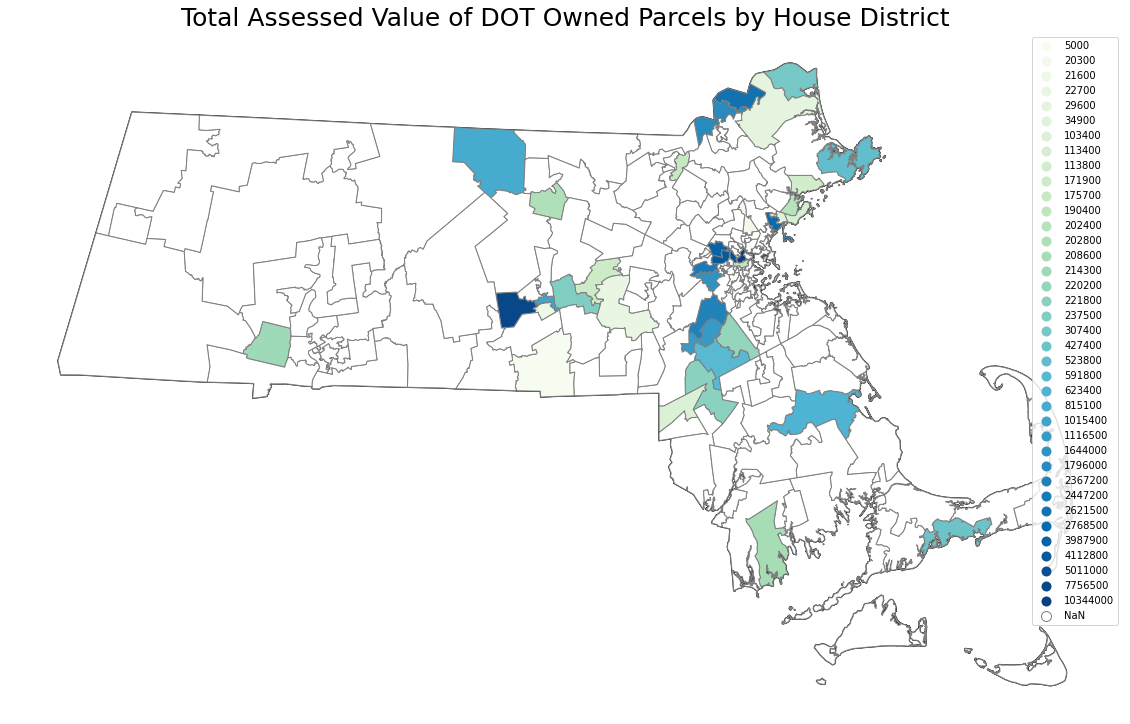

In [16]:
# MA House Leg Districts (https://www.mass.gov/info-details/massgis-data-massachusetts-house-legislative-districts#downloads-)
houseDistricts = gpd.read_file('/Users/hoperuse/summer2021internship/State Surplus/house2012/HOUSE2012_POLY.shp')

# Rename District column to match name in houseDistricts file
parcelsAgg = parcelsAgg.rename(columns = {'District': 'REP_DIST'})

# Geospatial merge of parcelsAgg and houseDistricts for mapping
merged = houseDistricts.merge(parcelsAgg, on = 'REP_DIST', how='left')

# Mapping total value of all parcels by House district
fig, ax = plt.subplots(figsize=(20,20))
houseDistricts.boundary.plot(ax=ax,edgecolor ='black',zorder=1)
vmin, vmax = min(parcelsAgg['TotalValue']), max(parcelsAgg['TotalValue'])
merged.plot(column='TotalValue',
        cmap='GnBu',
        ax=ax,
        edgecolor='gray',
        legend=True,
        # legend_kwds = {'orientation': "horizontal"},
        missing_kwds = {"color":"white"})
ax.axis('off')
ax.set_title('Total Assessed Value of DOT Owned Parcels by House District',fontdict={'fontsize': '25', 'fontweight' : '3'})

plt.savefig('totalValueDOT.png')

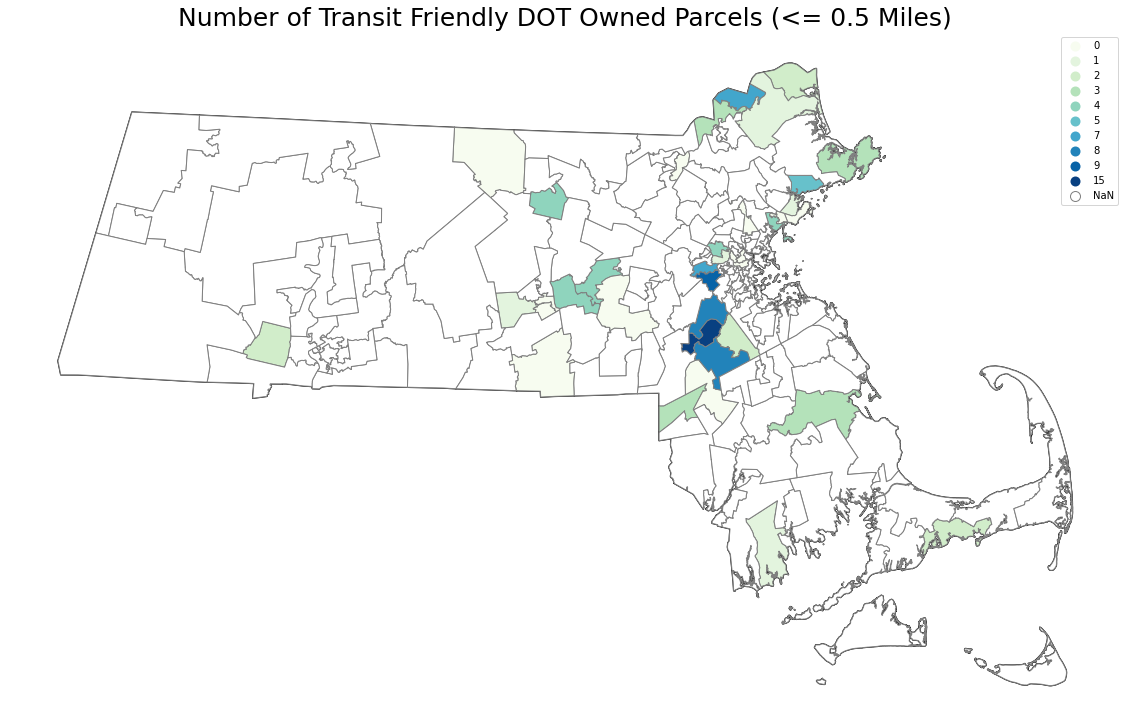

In [19]:
# Mapping total number of transit friendly DOT owned parcels by House district
fig, ax = plt.subplots(figsize=(20,20))
houseDistricts.boundary.plot(ax=ax,edgecolor ='black',zorder=1)
vmin, vmax = min(parcelsAgg['NumTransitFriendly']), max(parcelsAgg['NumTransitFriendly'])
merged.plot(column='NumTransitFriendly',
        cmap='GnBu',
        ax=ax,
        edgecolor='gray',
        legend=True,
        # legend_kwds = {'label': "Population by Country",'orientation': "horizontal"},
        missing_kwds = {"color":"white"})
ax.axis('off')
ax.set_title('Number of Transit Friendly DOT Owned Parcels (<= 0.5 Miles)',fontdict={'fontsize': '25', 'fontweight' : '3'})

plt.savefig('numTransitAvailDOT.png')